# Welcome to My Notes on The spelled-out intro to neural networks and backpropagation: building micrograd
- these are my notes on the Andrej Karpathy Zero to Hero Series: Entry 1
- [video link](https://youtu.be/VMj-3S1tku0?feature=shared)

In [13]:
%pip install -r ../requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Setting up Data Primitives
- we are building a class called Value that will be modeled off of Karpathy's [micrograd](https://github.com/karpathy/micrograd) library
- functions with a double underscore (`__example__`) are setup to work with Python's compiler
- to break down the fields:
  - data is used to hold the value of the parameter
  - grad is used to hold the backpropagation value when we want to update our NN
    - we are always doing += for gradient to comply with the multivariant chain rule
    - the gradient is our way of determining how the values should change given the output
      - this is effectively calculating derivatives for each function within our neural network
      - because the neural network functions accept previous function's output as input, the derivatives are all related, hence requiring us to use the chain rule to properly capture the relationships
  - _backward tells us how to calculate the gradient during backpropagation
    - this function is the derivative of the operation along with a pointer to previous derivatives to comply with the chain rule
  - _op, _label are mainly used to help with visualization later on

In [14]:
import math
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
        
    def __rsub__(self, other):
        return self + (-other)
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other): 
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        n = self.data
        out = Value(math.exp(n), (self, ), "exp")
        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        return out
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topology = []
        visited = set()
        def build_topology(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topology(child)
                topology.append(v)
        build_topology(self)
        self.grad = 1.0
        for node in reversed(topology):
            node._backward()


In [15]:
# Examples of the Python Compiler Connections

a = Value(2)
b = Value(3)
not_value = 4
c = a + b # __add__
d = not_value + a # __radd__
e = d * a ## __mul__
f = not_value * a ## __rmul__ 
a.exp()

Value(data=7.38905609893065)

## Graph Visualization Helper Code
- the below uses graphviz to visualize our neural network
- we output data & grad so we can visually confirm that our backward functions are working as expected

In [16]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid+n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

## Simple Network
- below we see a simple network using both inputs (x), weights (w) and bias (b)
- we run backward to confirm that our gradients are successfully passed through
- we then use our helper function `draw_dot` to visualize it all

In [17]:
# neuron
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# remember the weights will change via backpropagation
b = Value(6.8813735870195432, label="bias")
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = ((2*n).exp() - 1)/((2*n).exp()+1) # equal to tanh
o.label = "neuron"

In [18]:
o.backward()

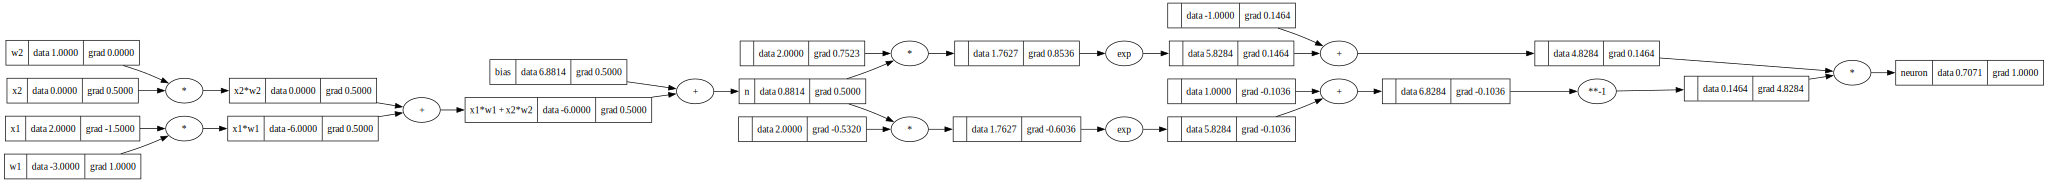

In [19]:
draw_dot(o)

# Building the equivalent in PyTorch
- pytorch has everything based around tensors rather than scalars
- Karpathy chose to make the two libraries closely resemble eachother as PyTorch is a commonly-used production environment

In [20]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True

# remember the weights will change via backpropagation
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True

n = x1 * w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("-"*5)
print("x1", x1.grad.item())
print("x2", x2.grad.item())
print("w1", w1.grad.item())
print("w2", w2.grad.item())

o.item()


0.7071066904050358
-----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


0.7071066904050358

# Setting up MLP Neural Network
- here we are building all 3 major parts of a neural network: neurons, layers, and Multi-layer perceptrons (MLP)
- neurons take in the input, weights, and biases, then use an activation function to determine what to pass through to the next neuron
- layers are groups of neurons that fire at the same time
- our Multi-Layer Perceptron (MLP) then combines multiple layers sequentially, enabling the network to learn hierarchical representations of data
- we create the parameters() function as an easy way to directly access all of the parameters on our model
  - this will let us zero out all of the gradients (zero_grad) later on during training easily

In [21]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b # takes 2 iterators and returns one that will go pair-wise (requires same length)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters() ]
    
class MLP:
    def __init__(self, nin, nout):
        sz = [nin] + nout
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nout))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters() ]

41


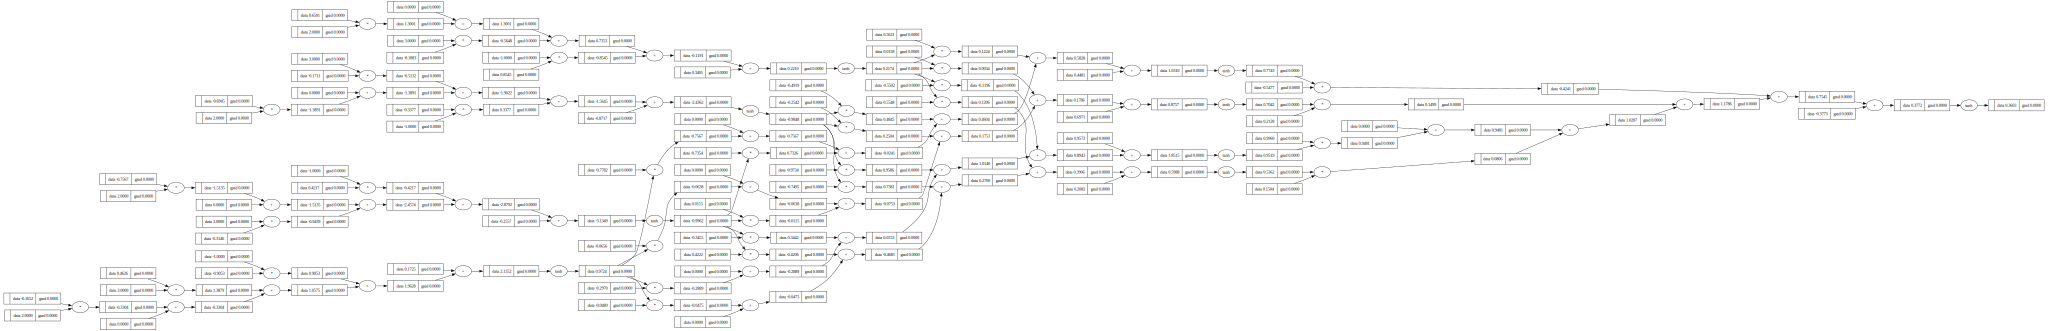

In [22]:
# building out a simple Neural network with 2 hidden layers, a 3D input, and a classier output (from -1 to 1)

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])

n(x)
print(len(n.parameters())) # total of 41 parameters

draw_dot(n(x))

# Simple Training Run
- we create a simple training set (3 entries) along with the expected output
- our goal is to find the loss during the run, a value that will tell us how close we're getting to the desired behavior
    - the lower the loss, the better
- for each entry, we perform a forward pass to get our predicted outputs
- we then compare the expected output with the predicted outputs
  - there are many ways to compare these, we chose mean squared error (MSE) as it is simple to compute and seems to do a fairly good job optimizing our model
- because our gradients accumulate during backwards propagation, we will set them all equal to 0 at the beginning to avoid adding to them between runs
- once that's completed, we then do our backwards run to calculate all of the gradients for each parameter
- with the gradients found, we can then run through each parameter and add to it
  - note, we choose some small part of the gradient to add to the parameter to avoid overfitting and making dramatic parameter updates (0.05)
    - this is called the learning rate

In [23]:
# tiny training set
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]


for k in range(20): # 20 is chosen arbitraily here
    ypreds = [n(x) for x in xs]
    loss = sum((yop-ygt)**2 for ygt, yop in zip(ys, ypreds))

    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    for p in n.parameters():
        p.data += p.grad * -0.05 # negative here is used so we MINIMIZE the loss

    print(k, loss.data)

0 4.192427852546952
1 3.2609435918362673
2 2.333260515529524
3 1.1600527461655359
4 0.610312959381097
5 0.3935660533354776
6 0.2906954707302619
7 0.22924264302868064
8 0.1885785318982969
9 0.15975561185759823
10 0.1382979014119024
11 0.12172549948104312
12 0.10855585479416592
13 0.09784911242972774
14 0.08898105071887949
15 0.08152108377381433
16 0.07516272629933557
17 0.06968198225807164
18 0.06491140534713005
19 0.06072335690110136


In [24]:
ypreds = [n(x) for x in xs]
ypreds # these should approach 1, -1, -1, and 1

[Value(data=0.8993648139530909),
 Value(data=-0.8855472738468327),
 Value(data=-0.8646669308831421),
 Value(data=0.8755935498620329)]

## Methods We Will Use As We Advance:
- learning rate: using scheduler, choosing distinct values
- different loss functions: eg cross entropy loss
- different architectures for network
- hardware optimization: writing our data to be performant on specific devices